# Trabajo Integrador Parte 4

Nombre: Javier Cambiasso

Dentro de la carpeta de `data/` vamos a poder encontrar 3 datasets:

- Pokemon (Problema de clasificacion Binaria): La intención es tratar de predecir si basada en la información que tenemos podemos estimar si la carta que estamos viendo es Legendaria o no (Booleano).
- Heart Disease (Problema de clasificacion Binaria): A partir de este dataset vamos a tratar de determinar si una persona basado en ciertos datos tiene asociado una enfermedad cardiaca.
- Challenger USA Space Shuttle O-Ring Data Set (Regresion multivariada): En este dataset encontramos información sobre varios despegues del space shuttle, la intención de este problema es tratar de predecir cuanto será la cantidad de O-Rings que fallan dadas las condiciones de despegue.

> Para la presentación de sus trabajos prácticos **Elijan 1 de los 3 datasets**

# Importar librerías

Importar aquellas librerías que serán utilizadas en el trabajo.

In [1252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [1253]:
#Le robo este plotter de matrices de confusion a https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.3f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Cargar datos

Cargar los datos de entrenamiento.

Recordemos que para todos los datasets tenemos el archivo `columns.csv` que contiene el nombre y descripción de cada columna en el mismo orden que van a encontrar los datos.

En los casos de datos con extensión  `*.data` vamos a tener que leerlo utilizando `pd.read_data('myfile.data', sep = ',', header = 0, names = my_cols)`

De esta manera si quisieramos cargar datos por ejemplo de Nasa deberiamos poner algo asi


```python
## Importing python earlier

my_cols = pd.read_csv('./data/nasa_orings/columns.csv').column.values.tolist()

my_data = pd.read_csv('./data/nasa_orings/o-ring-erosion-or-blowby.data',
                       delimiter=',',
                       header=0,
                       names = my_cols
                    )
```

In [1254]:
#Uso Pokemon
DATASET_PATH = "./data/pokemon/"

In [1255]:
my_cols = pd.read_csv(DATASET_PATH + 'columns.csv').column.values.tolist()

my_data = pd.read_csv(DATASET_PATH + 'pokemon.csv',
                       delimiter=',',
                       header=0,
                       converters={'abilities' : (lambda x : x[1:-1].split(','))}
                    )

# Análisis exploratorio básico y preprocesamiento de los datos

Análisis de los datos para conocer los mismos, ver datos faltantes, decidir cómo tratarlos, ver distribuciones, relaciones, etc. Procesar los datos centrándolos, reescalando, codificando, reduciendo dimensiones, etc. según considere necesario.

Vamos a considerar:

- Para escalar datos: `sklearn.preprocessing.StandardScaler()`
- Para completar valores nulos: `sklearn.impute.SimpleImputer()` [Quickguide](https://scikit-learn.org/stable/modules/impute.html)
- Para reduccion de dimensiones (sobre todo para visualizar los datos): PCA o [T-SNE](https://builtin.com/data-science/tsne-python) (Solo para visualización)
- Para codificar variables categóricas: `sklearn.preprocessing.OneHotEncoder()`

In [1256]:
my_data.describe()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,height_m,hp,percentage_male,pokedex_number,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,781.000000,801.000000,703.000000,801.000000,801.000000,801.000000,801.000000,781.000000,801.000000,801.000000
mean,0.996255,1.057116,0.968789,1.073970,1.068976,1.065543,1.135456,1.192884,0.985019,1.034020,...,1.163892,68.958801,55.155761,401.000000,71.305868,70.911361,66.334582,61.378105,3.690387,0.087391
std,0.597248,0.438142,0.353058,0.654962,0.522167,0.717251,0.691853,0.604488,0.558256,0.788896,...,1.080326,26.576015,20.261623,231.373075,32.353826,27.942501,28.907662,109.354766,1.930420,0.282583
min,0.250000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000,...,0.100000,1.000000,0.000000,1.000000,10.000000,20.000000,5.000000,0.100000,1.000000,0.000000
25%,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,1.000000,1.000000,0.500000,...,0.600000,50.000000,50.000000,201.000000,45.000000,50.000000,45.000000,9.000000,2.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,65.000000,50.000000,401.000000,65.000000,66.000000,65.000000,27.300000,4.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.500000,80.000000,50.000000,601.000000,91.000000,90.000000,85.000000,64.800000,5.000000,0.000000
max,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,14.500000,255.000000,100.000000,801.000000,194.000000,230.000000,180.000000,999.900000,7.000000,1.000000


# Preproceso

In [1257]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#Preproceso un poco los datos.

#Primero, voy a convertir "abilities" en la suma de habilidades y ver que pasa con esa columna de listas.
my_data['num_abilities'] = my_data['abilities'].apply(lambda x: len(x))

total = []
for lst in my_data.abilities:
    total = total + lst

print(my_data.drop('abilities',axis=1).groupby(['is_legendary','num_abilities']).size())
print(f'Total unique abilities is: {np.unique(np.array(total)).shape[0]}')

is_legendary  num_abilities
0             1                 65
              2                224
              3                422
              4                  7
              6                 13
1             1                 44
              2                 21
              3                  5
dtype: int64
Total unique abilities is: 339


Aparentemente ninguna legendaria tiene más de 3 habilidades, y además, dentro de las legendarias, suelen tener 1 sola habilidad (en el 62% de los casos). Ya aca sabemos que cualquier bicho con 4 o más habilidades, no es legendaria. El número de habilidades es entonces un feature interesante.

Siguiendo con las habilidades, la cantidad única es muy grande. Estaba tentando en agregar un feature por habilidad que sea 'has_[ability]', pero para empezar, es demasiado. Veamos si hay habilidades propias de las legendarias: 

In [1258]:
#Miro algunos features categoricos o ese raro de habilidades

def get_uniques(data): #Hay alguna forma mejor de hacer esto?
    uniques = []
    for lst in data:
        uniques = uniques + lst
    return np.unique(np.array(uniques))

print(get_uniques(my_data['abilities'].to_numpy()).shape[0])
#print(get_uniques(my_data.loc['abilities'].to_numpy()).shape[0])

#loc busca por nombre de columna y acepta arrays de booleanos, que aprovecho con el indexing condicional.
legend_abilities = my_data.loc[my_data['is_legendary']==1,'abilities'].to_numpy()
legend_abilities = get_uniques(legend_abilities)

non_legend_abilities = my_data.loc[my_data['is_legendary']==0,'abilities'].to_numpy()
non_legend_abilities = get_uniques(non_legend_abilities)

only_legend = legend_abilities[np.logical_not(np.in1d(legend_abilities,non_legend_abilities))]
only_non_legend = non_legend_abilities[np.logical_not(np.in1d(non_legend_abilities,legend_abilities))]
print(f'Hay {only_legend.shape[0]} habilidades que solo tienen las legendarias y {only_non_legend.shape[0]} no legendarias')

#Veo si 'classfication' tiene algo muy propio de las legendarias (que se yo, tipo 'god' o algo así)
legend_class = my_data.loc[my_data['is_legendary']==1,'classfication'].unique()
non_legend_class = my_data.loc[my_data['is_legendary']==0,'classfication'].unique()

legend_only_class = legend_class[np.logical_not(np.in1d(legend_class,non_legend_class))]
non_legend_only_class = non_legend_class[np.logical_not(np.in1d(non_legend_class,legend_class))]
print(legend_only_class)
print(f'Hay {legend_only_class.shape[0]} clases unicas legendarias y {non_legend_abilities.shape[0]} clases no legendarias unicas')
print(non_legend_only_class)
print(my_data.loc[(my_data.classfication == 'Sea Cucumber Pokémon'), ['name','is_legendary']])

339
Hay 29 habilidades que solo tienen las legendarias y 282 no legendarias
['Freeze Pokémon' 'Genetic Pokémon' 'New Species Pokémon'
 'Thunder Pokémon' 'Aurora Pokémon' 'Diving Pokémon' 'Rainbow Pokémon'
 'Time Travel Pokémon' 'Rock Peak Pokémon' 'Iron Pokémon' 'Eon Pokémon'
 'Sea Basin Pokémon' 'Sky High Pokémon' 'Wish Pokémon' 'DNA Pokémon'
 'Knowledge Pokémon' 'Willpower Pokémon' 'Temporal Pokémon'
 'Spatial Pokémon' 'Lava Dome Pokémon' 'Colossal Pokémon'
 'Renegade Pokémon' 'Lunar Pokémon' 'Seafaring Pokémon'
 'Pitch-Black Pokémon' 'Gratitude Pokémon' 'Alpha Pokémon'
 'Victory Pokémon' 'Iron Will Pokémon' 'Cavern Pokémon'
 'Grassland Pokémon' 'Cyclone Pokémon' 'Bolt Strike Pokémon'
 'Vast White Pokémon' 'Deep Black Pokémon' 'Abundance Pokémon'
 'Boundary Pokémon' 'Colt Pokémon' 'Melody Pokémon' 'Paleozoic Pokémon'
 'Life Pokémon' 'Destruction Pokémon' 'Order Pokémon'
 'Mischief Pokémon (Confined)Djinn Pokémonn (Unbound)' 'Steam Pokémon'
 'Land Spirit Pokémon' 'Nebula Pokémon' 'Pro

Hay muchas habilidades disjuntas en ambas clases, y la verdad muy pocas que intersequen. Eso me da la pauta de que las habilidades son más propias del pokemon en sí que de cualquier otro feature, así que la puedo droppear. 

Con la columnna 'classfication' pasa lo mismo, pero con algún conocimiento de causa, es muy posible que un pokemon New Species, Time Travel o directamente una nebulosa (Cosmog), sea legendario, mientras que un Sea Cucumber no. Por otro lado, un Emperor Pokemon no es legendario. Esto entra en lo que es procesamiento de lenguaje y por ahora droppeo classfication.

No sé, me quedé en los 150. Esto es el Sea Cucumber por cierto:

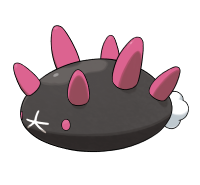

In [1259]:
import re
import math

#A ver que hay de columnas numericas
print(my_data.select_dtypes([np.number]).columns)

#Hay un capture rate muy roto por ahi, lo tengo que buscar con un regex
capture = my_data.capture_rate.to_numpy()
non_numeric = []
for i in range(capture.shape[0]):
    if not re.search('^[0-9]+$', str(capture[i])):
        non_numeric.append(i)     
#Fijo esos en la media de todos los que si pueden pasarse a int.
if not len(non_numeric) == 0:
    mean_numeric_capture_rate = math.ceil(my_data.drop(my_data.index[non_numeric],axis=0).capture_rate.astype(int).mean())
    #Tengo que hacer todo esto para indexar por (lista de) index | Label?
    #iloc es solo por posicion, get_indexer obtengo el indice de label en cuestio, y asignaciones con iloc/loc modifican el dataframe de una.
    my_data.iloc[non_numeric,my_data.columns.get_indexer(['capture_rate'])] = mean_numeric_capture_rate

#Y paso todo capture_rate a int
my_data['capture_rate'] = my_data['capture_rate'].astype(int)

#Droppeo las columnas que no sirven para nada
data = my_data.drop(['abilities','japanese_name','name','classfication'],axis=1)

#Separo en tipos (numerico, ordinal y categorico.)
target = ['is_legendary']
#Me asegura de droppear los targets
numerical_features = data.drop(target,axis=1).select_dtypes([np.number]).columns
categorical_features= data.drop(target,axis=1).columns[np.logical_not(np.in1d(data.drop(target,axis=1).columns, numerical_features))]
print(numerical_features)
print(categorical_features)

#Completo np.nans
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

imp_cat.fit(data[categorical_features])
imp_num.fit(data[numerical_features])

data[categorical_features] = imp_cat.transform(data[categorical_features])
data[numerical_features] = imp_num.transform(data[numerical_features])
data


Index(['against_bug', 'against_dark', 'against_dragon', 'against_electric',
       'against_fairy', 'against_fight', 'against_fire', 'against_flying',
       'against_ghost', 'against_grass', 'against_ground', 'against_ice',
       'against_normal', 'against_poison', 'against_psychic', 'against_rock',
       'against_steel', 'against_water', 'attack', 'base_egg_steps',
       'base_happiness', 'base_total', 'defense', 'experience_growth',
       'height_m', 'hp', 'percentage_male', 'pokedex_number', 'sp_attack',
       'sp_defense', 'speed', 'weight_kg', 'generation', 'is_legendary',
       'num_abilities'],
      dtype='object')
Index(['against_bug', 'against_dark', 'against_dragon', 'against_electric',
       'against_fairy', 'against_fight', 'against_fire', 'against_flying',
       'against_ghost', 'against_grass', 'against_ground', 'against_ice',
       'against_normal', 'against_poison', 'against_psychic', 'against_rock',
       'against_steel', 'against_water', 'attack', 'base_eg

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,num_abilities
0,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1.0,65.0,65.0,45.0,grass,poison,6.9,1.0,0,2.0
1,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,2.0,80.0,80.0,60.0,grass,poison,13.0,1.0,0,2.0
2,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,3.0,122.0,120.0,80.0,grass,poison,100.0,1.0,0,2.0
3,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,4.0,60.0,50.0,65.0,fire,flying,8.5,1.0,0,2.0
4,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,5.0,80.0,65.0,80.0,fire,flying,19.0,1.0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,0.25,...,797.0,107.0,101.0,61.0,steel,flying,999.9,7.0,1,1.0
797,1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,0.25,...,798.0,59.0,31.0,109.0,grass,steel,0.1,7.0,1,1.0
798,2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,0.50,...,799.0,97.0,53.0,43.0,dark,dragon,888.0,7.0,1,1.0
799,2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.00,...,800.0,127.0,89.0,79.0,psychic,flying,230.0,7.0,1,1.0


Por suerte, target (is_legendary) ya esta binarizada.

In [1260]:
data[target].value_counts()

is_legendary
0               731
1                70
Name: count, dtype: int64

In [1261]:
def class_decode(y):
    if y == 1:
        return 'legendary'
    elif y == 0:
        return 'non_legend'
    else:
        return 'Nan'

#dim class 1,N
y_class = data[target].to_numpy().reshape(-1,)
y_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [1262]:
dummies = pd.get_dummies(data[categorical_features])
dummies

,type1_bug,type1_dark,type1_dragon,type1_electric,type1_fairy,type1_fighting,type1_fire,type1_flying,type1_ghost,type1_grass,...,type2_ghost,type2_grass,type2_ground,type2_ice,type2_normal,type2_poison,type2_psychic,type2_rock,type2_steel,type2_water
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
797,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
798,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
799,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [1263]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[numerical_features])
print(X_scaled)
pca = PCA(n_components=0.9).fit(X_scaled)
pca.n_components_

[[ 6.27488230e-03 -1.30441376e-01  8.84572052e-02 ... -5.04839391e-01
  -1.39455066e+00 -5.59576543e-01]
 [ 6.27488230e-03 -1.30441376e-01  8.84572052e-02 ... -4.48311722e-01
  -1.39455066e+00 -5.59576543e-01]
 [ 6.27488230e-03 -1.30441376e-01  8.84572052e-02 ...  3.57902573e-01
  -1.39455066e+00 -5.59576543e-01]
 ...
 [ 1.68166846e+00 -1.27233802e+00  2.92262606e+00 ...  7.66016538e+00
   1.71552381e+00 -1.72681824e+00]
 [ 1.68166846e+00  2.15335190e+00  8.84572052e-02 ...  1.56259060e+00
   1.71552381e+00 -1.72681824e+00]
 [-1.25027030e+00 -1.27233802e+00 -2.74571165e+00 ...  1.77199369e-01
   1.71552381e+00 -1.72681824e+00]]


20

In [1264]:
X_transformed = pca.transform(X_scaled)

In [1265]:
X_transformed

array([[-2.04740218, -1.36873293,  0.7940212 , ...,  1.06549362,
        -0.71022042,  0.16328492],
       [-0.94634952, -1.52677812,  0.75296547, ...,  0.98241283,
        -0.76484527,  0.20459454],
       [ 2.10122994, -1.73531631,  0.65864015, ...,  0.44879739,
        -0.83513404,  0.77122797],
       ...,
       [ 8.30819965, -3.17456438, -5.54412148, ...,  1.33679688,
         2.568358  , -1.12390625],
       [ 5.81072887, -1.44673406,  2.12801895, ..., -1.14635127,
        -1.09690821, -0.74563134],
       [ 5.0057934 ,  1.21460791,  1.63192837, ...,  0.51317065,
        -0.56017893, -1.97457321]])

<Axes: >

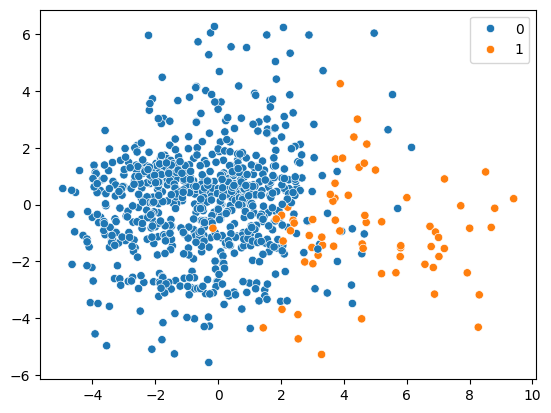

In [1266]:
sns.scatterplot(x=X_transformed[:,0], y=X_transformed[:,1], hue=y_class)

# Modelos y evaluación
Probar diferentes modelos para predecir la variable objetivo. Calcular las métricas que considere relevantes. Comentar los resultados. 

Con PCA se ve algo separable por un clasificador lineal. Pruebo clasificar con una regresión logística en el espacio reducido de PCA.

In [1267]:
random_state = 43

In [1268]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X_transformed,y_class, train_size=0.7,test_size=0.3,random_state=random_state)
logit = LogisticRegression(multi_class='auto',penalty='l2',solver='lbfgs')
logit.fit(X_train,y_train)
print(logit.coef_[0,0])
print(logit.intercept_)

1.520102127972943
[-7.17009418]


Si la relación entre el logaritmo de las probabilidades condionales de la clases según la muestra es igual al modelo lineal, es decir:
$$
\ln \frac{P(G=legendario | X= x)}{P(G=no\_legendario| X = x)} = \beta_0 + \mathbf{\beta}^T \mathbf{X}
$$

Cuando las probabilidades son iguales, la relación de logaritmos (log-odds) es 0, y eso dibuja la recta de decisión. Tomando solo dos features:
$$
\beta_0 + \mathbf{\beta}^T \mathbf{X} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 = 0
$$
$$
X_2 = -\frac{\beta_0}{\beta_1} - \frac{\beta_1}{\beta_2}X_1
$$

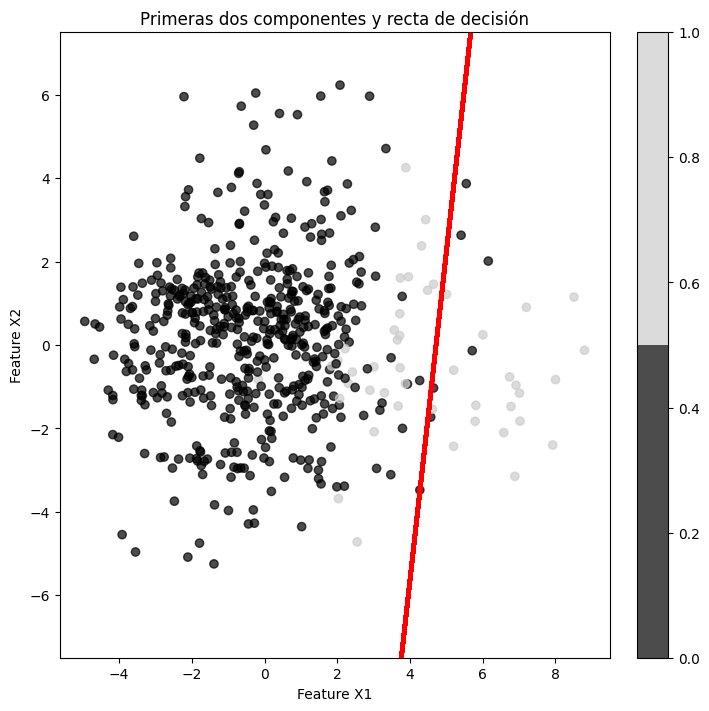

In [1269]:
#Los coeficientes es una matriz porque LogisticRegression soporta multiclase; En el esquema one-vs-rest (OVR) 
#cada fila i de coeficientes corresponde a la relación de la clase i contra la suma de las demás, y conserva la idea
#de la relación de logaritmos de "esta clase o no" de la clasificación binaria.
slope = -(logit.coef_[0,0]/logit.coef_[0,1])
intercep = -(logit.intercept_/logit.coef_[0,1])

fig,ax = plt.subplots(figsize=(7, 7),layout='constrained')
ax1 = ax.scatter(X_train[:,0],X_train[:,1], c=y_train, cmap=plt.colormaps['nipy_spectral'].resampled(2),alpha=0.7)
ax.plot(X_train[:,0], intercep + slope*X_train[:,0], color='red', linewidth = 3)
ax.set_title('Primeras dos componentes y recta de decisión')
ax.set_xlabel('Feature X1')
ax.set_ylabel('Feature X2')
plt.ylim((-7.5, 7.5))
fig.colorbar(ax1,ax=ax)
plt.show()

[[ 21   3]
 [  0 217]]
[[1.         0.01363636]
 [0.         0.98636364]]


,Accuracy,Precision,Recall
0,0.987552,1.0,0.875


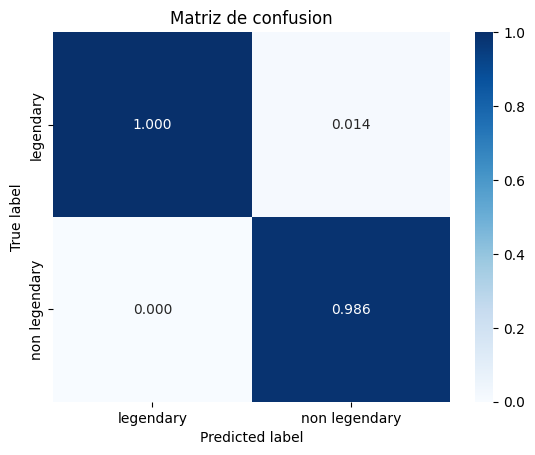

In [1270]:
#Se ve feo, pero es probable que sea por la regularización.
# a ver las metricas

#Por defecto, el umbral de decisión es 0.5
y_pred = logit.predict_proba(X_test)
y_pred = logit.predict(X_test)

metrics = pd.DataFrame()
#Acomodo la matriz de confusion con 'labels=' porque si no, ajusta las clases en orden y no coincide con la variable a reportar (es legendario = 1)
print(confusion_matrix(y_true=y_test, y_pred=y_pred,labels=[1,0]))
cf = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='pred', labels=[1,0])
print(cf)

make_confusion_matrix(cf, title='Matriz de confusion',percent=False,sum_stats=False,categories=['legendary','non legendary'],count=True)

metrics['Accuracy'] = [accuracy_score(y_true=y_test, y_pred=y_pred)]
metrics['Precision'] = [precision_score(y_true=y_test, y_pred=y_pred)]
metrics['Recall'] = [recall_score(y_true=y_test, y_pred=y_pred)]
metrics

El recall dio relativamente bajo. El recall era
$$
Recall = \frac{TP}{TP + FN}
$$
Esta metrica indica más o menos cuan bueno es el modelo en detectar valores verdaderamente positivos (osea, pokemones legendarios), porque estoy mirando la relación entre los correctamente predichos (TP) contra todos los realmente eran positivos (FN+TP).

Me intriga rapidamente el discriminante cuadratico sobre el espacio reducido:

[[ 19   5]
 [  1 216]]
[[0.95       0.02262443]
 [0.05       0.97737557]]


,Accuracy,Precision,Recall
0,0.975104,0.95,0.791667


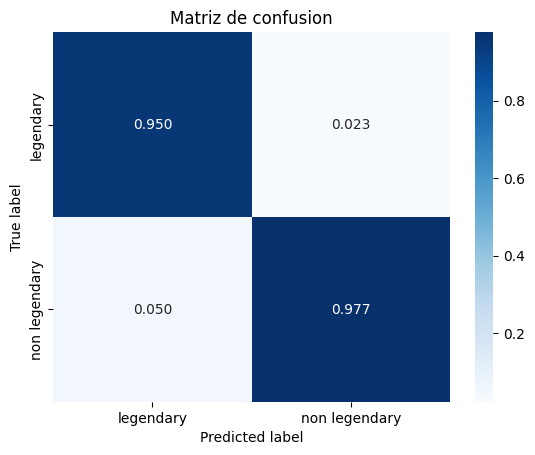

In [1271]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#Dejo los priors para que se calcule su frecuencia automaticamente
model = QuadraticDiscriminantAnalysis()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_true=y_test, y_pred=y_pred,labels=[1,0]))
cf = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='pred', labels=[1,0])
print(cf)

make_confusion_matrix(cf, title='Matriz de confusion',percent=False,sum_stats=False,categories=['legendary','non legendary'],count=True)

metrics['Accuracy'] = [accuracy_score(y_true=y_test, y_pred=y_pred)]
metrics['Precision'] = [precision_score(y_true=y_test, y_pred=y_pred)]
metrics['Recall'] = [recall_score(y_true=y_test, y_pred=y_pred)]
metrics

Curiosamente dio peor, siendo cuadratico y todo. Ahora, lo que me intriga es la regesión logística en el espacio original de características, sin aplicar PCA. Primero, entonces, puedo unir los resultados del OneHote de Pandas al dataframe original:

In [1272]:
#True-False es categorico y castea a 0-1 automaticamente
data_dm = data.join(dummies)
data_dm

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,type2_ghost,type2_grass,type2_ground,type2_ice,type2_normal,type2_poison,type2_psychic,type2_rock,type2_steel,type2_water
0,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,False,False,False,False,False,True,False,False,False,False
1,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,False,False,False,False,False,True,False,False,False,False
2,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,False,False,False,False,False,True,False,False,False,False
3,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,False,False,False,False,False,False,False,False,False,False
4,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,0.25,...,False,False,False,False,False,False,False,False,False,False
797,1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,0.25,...,False,False,False,False,False,False,False,False,True,False
798,2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,0.50,...,False,False,False,False,False,False,False,False,False,False
799,2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.00,...,False,False,False,False,False,False,False,False,False,False


In [1273]:
#Seteo el indice para los features a comparar, porque ahora es mas raro graficiar la recta de decision
feature_x = 20
feature_y = 22
print(data.iloc[:,feature_x].name)
print(data.iloc[:,feature_y].name)

base_happiness
capture_rate


     against_bug  against_dark  against_dragon  against_electric  \
0           1.00           1.0             1.0               0.5   
1           1.00           1.0             1.0               0.5   
2           1.00           1.0             1.0               0.5   
3           0.50           1.0             1.0               1.0   
4           0.50           1.0             1.0               1.0   
..           ...           ...             ...               ...   
796         0.25           1.0             0.5               2.0   
797         1.00           1.0             0.5               0.5   
798         2.00           0.5             2.0               0.5   
799         2.00           2.0             1.0               1.0   
800         0.25           0.5             0.0               1.0   

     against_fairy  against_fight  against_fire  against_flying  \
0              0.5            0.5           2.0             2.0   
1              0.5            0.5           2.0  

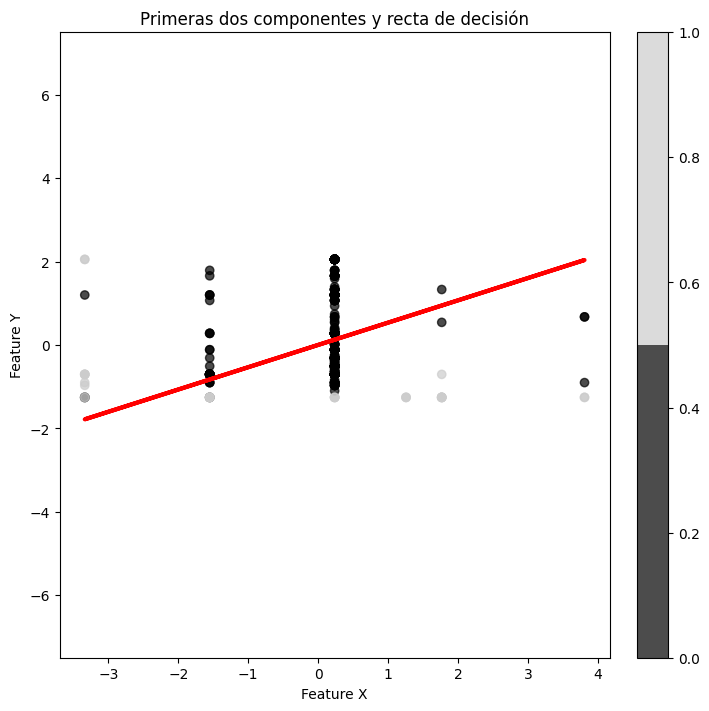

[[ 23   1]
 [  0 217]]
[[1.         0.00458716]
 [0.         0.99541284]]


,Accuracy,Precision,Recall
0,0.995851,1.0,0.958333


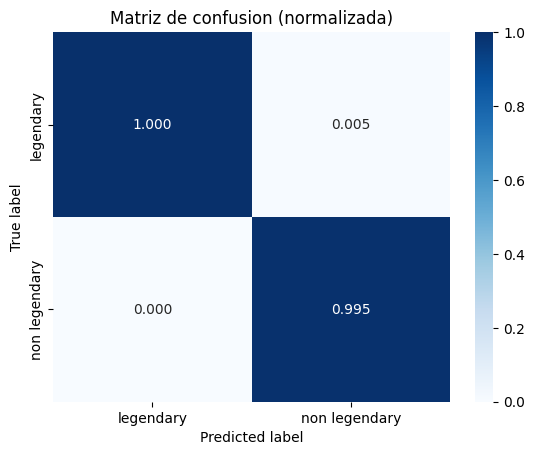

In [1274]:
data_dm = data_dm.drop(target,axis=1)
data_dm = data_dm.drop(categorical_features,axis=1)
print(data_dm)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_dm)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_class, train_size=0.7,test_size=0.3,random_state=random_state)
logit = LogisticRegression(multi_class='auto',penalty='l2',solver='lbfgs')
logit.fit(X_train,y_train)
print(logit.coef_[0,0])
print(logit.intercept_)

slope = -(logit.coef_[0,feature_x]/logit.coef_[0,feature_y])

fig,ax = plt.subplots(figsize=(7, 7),layout='constrained')
ax1 = ax.scatter(X_train[:,feature_x],X_train[:,feature_y], c=y_train, cmap=plt.colormaps['nipy_spectral'].resampled(2),alpha=0.7)
ax.plot(X_train[:,feature_x], slope*X_train[:,feature_x], color='red', linewidth = 3)
ax.set_title('Primeras dos componentes y recta de decisión')
ax.set_xlabel('Feature X')
ax.set_ylabel('Feature Y')
plt.ylim((-7.5, 7.5))
fig.colorbar(ax1,ax=ax)
plt.show()

y_pred = logit.predict_proba(X_test)
y_pred = logit.predict(X_test)

metrics = pd.DataFrame()
#Acomodo la matriz de confusion con labels porque si no acomoda en orden y no coincide con la variable a reportar (es legendario = 1)
print(confusion_matrix(y_true=y_test, y_pred=y_pred,labels=[1,0]))
cf = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='pred',labels=[1,0])
print(cf)

make_confusion_matrix(cf, title='Matriz de confusion (normalizada)',percent=False,sum_stats=False,categories=['legendary','non legendary'],count=True)

metrics['Accuracy'] = [accuracy_score(y_true=y_test, y_pred=y_pred)]
metrics['Precision'] = [precision_score(y_true=y_test, y_pred=y_pred)]
metrics['Recall'] = [recall_score(y_true=y_test, y_pred=y_pred)]
metrics

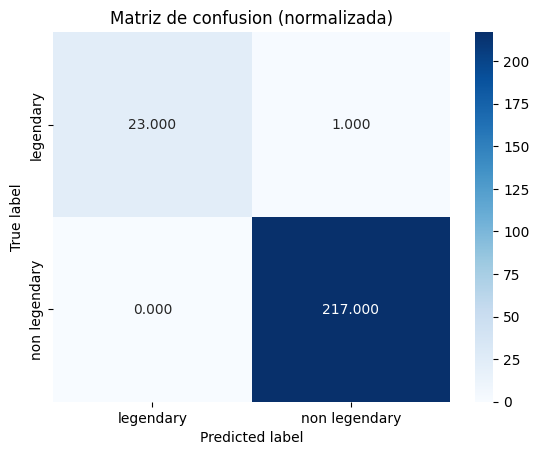

In [1275]:
cf = confusion_matrix(y_true=y_test, y_pred=y_pred,labels=[1,0])
make_confusion_matrix(cf, title='Matriz de confusion (normalizada)',percent=False,sum_stats=False,categories=['legendary','non legendary'],count=True)

# Algunas conclusiones

Con random_state en 43 (para el split de trin/set), la diferencia entre la clasificación sin los features categóricos y pasado por PCA con una varianza acumulada del 90%, la diferencia estuvo en el recall: hubo 21 TP con 3 FN para los legendarios totales, mientras que aplicando el One Hot encoder y usando para la clasificación más del triple de features, solo se mejoró en el recall para 23 TP con solo 1 FN. 

La clasificación logística para este dataset usando PCA resulta ser bastante bueno y el modelo completo, sin PCA, termina con métricas y para un split del 30% de datos para test: 

| Accuracy | Precision | Recall |
| --- | --- | --- |
| 0.995851 | 1.0 | 0.958333 |

Curiosamente, entonces resulta que hay un conjunto características que hacen a los pokémon legendarios; puedo, usando este modelo, encontrarlos el 95% de las veces, y en general predecir correctamente su clase un 99% de las veces. Me gustaría saber cuales (en la órbita de "haceme un pokémon legendario"; supongo que entramos en el terreno de los modelos generativos). Además se podria hacer una simulación para diferentes seeds de split, y comparar con QDA también sin PCA.